In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import  Dataset,random_split,DataLoader

In [2]:
batch_size = 128
num_worker = 0

In [3]:
# 定义一个名为 plot_series 的函数，用于绘制时间序列图
def plot_series(time, plot_series, format='-', start=0, end=None, label=None):
    # 使用 matplotlib 绘制时间序列图
    plt.plot(time[start:end], plot_series[start:end], format, label=label)
    plt.xlabel("Time")  # x轴标签
    plt.ylabel("Value")  # y轴标签
    if label:  # 如果提供了标签
        plt.legend(fontsize=14)  # 显示图例
    plt.grid(True)  # 显示网格
    plt.show()  # 显示图像


In [4]:
# 定义名为 trend 的函数，用于生成趋势数据
def trend(time, slope=0):
    """
    生成趋势数据。

    参数:
    time (list): 时间的列表。
    slope (float): 坡度，默认为0。
    """
    return (slope * time)

# 定义名为 whtie_noise 的函数，用于生成白噪声数据
def whtie_noise(time, std=1.0, seed=None):
    """
    生成白噪声数据。

    参数:
    time (list): 时间的列表。
    std (float): 标准差，默认为1.0。
    seed (int): 种子数，默认为None。
    """
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * std

# 定义名为 seasonal_pattern 的函数，用于生成季节性模式数据
def seasonal_pattern(season_time):
    """
    生成季节性模式数据。

    参数:
    season_time (list): 季节时间的列表。
    """
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

# 定义名为 seasonality 的函数，用于生成季节性数据
def seasonality(time, period, amplitude=1, phase=0):
    """
    生成季节性数据。

    参数:
    time (list): 时间的列表。
    period (int): 周期数。
    amplitude (int): 振幅，默认为1。
    phase (int): 相位，默认为0。
    """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
def train_test_split(series, split_fraction=0.7):
    """
    将数据集划分为训练集和测试集。

    参数:
    series (list): 输入的时间序列数据。
    split_fraction (float): 划分的比例，默认为0.7。

    返回:
    train_set (list): 训练集数据。
    test_set (list): 测试集数据。
    """
    train_size = int(len(series) * split_fraction)
    train_set = series[:train_size]
    test_set = series[train_size:]
    return train_set, test_set


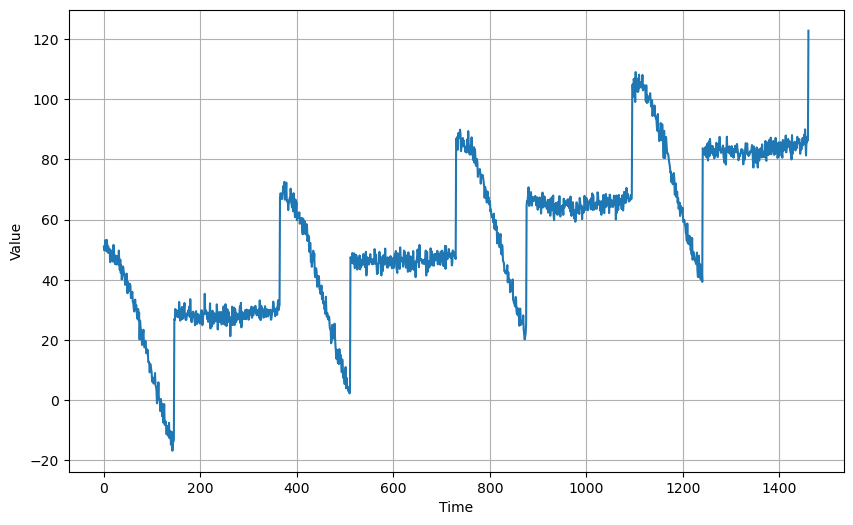

In [5]:

time = np.arange(4 * 365 + 1)
baseline = 10
slope = 0.05
amplitude = 40
noise_level = 2

# 生成时间序列数据
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + whtie_noise(time, noise_level, seed=42)
series = series.astype(np.double)

# 绘制时间序列图
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()


In [6]:



class my_Dataset(Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class TrafficDataset:
    def __init__(self, Data=None,sensor=10, target=0):
        # 选取适当的检测器用作序列数据
        self.raw_data = Data
        print(self.raw_data.shape)
        self.sensor = sensor
        self.target = target
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, window_size=12, split=0.6):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []

        len_train = int(self.raw_data.shape[0] * split)
        train_seqs = self.raw_data[:len_train]
        remain_len = len_train+int((self.raw_data.shape[0] - len_train)/2)


        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i+window_size].squeeze())
            train_y.append(train_seqs[i+window_size].squeeze())

        # 补全构造过程

        val_seqs=self.raw_data[len_train:remain_len]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(val_seqs[i:i+window_size].squeeze())
            val_y.append(val_seqs[i+window_size].squeeze())


        test_seqs=self.raw_data[remain_len:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i+window_size].squeeze())
            test_y.append(test_seqs[i+window_size].squeeze())
        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set
t=TrafficDataset(series)
train_set, val_set, test_set=t.construct_set()
print(train_set.__len__(),val_set.__len__(),test_set.__len__())
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=num_worker,drop_last=True)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=num_worker,drop_last=True)
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=num_worker,drop_last=True)

(1461,)
864 280 281


C:\Users\zx131\AppData\Local\Temp\ipykernel_18604\431851983.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))


In [7]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers):
        super(RNN,self).__init__()
        self.rnn=nn.RNN(input_size,hidden_size,num_layers,batch_first=True)
        self.linear=nn.Linear(hidden_size,output_size)
    def forward(self,x):
        out,_=self.rnn(x)
        out=self.linear(out[:,-1,:])
        return out
    

In [8]:
# train
epoch_num = 100
lr = 0.01
model=RNN(1,10,1,1)
opt = torch.optim.Adam(model.parameters(), lr=lr)
loss = nn.MSELoss()
for epoch in range(epoch_num):
    for x,y in train_loader:
        out=model(x.unsqueeze(2))
        l=loss(out,y.unsqueeze(1))
        opt.zero_grad()
        l.backward()
        opt.step()
        

tensor(1960.1753, grad_fn=<MseLossBackward0>)
tensor(1777.3086, grad_fn=<MseLossBackward0>)
tensor(1684.2698, grad_fn=<MseLossBackward0>)
tensor(1925.4506, grad_fn=<MseLossBackward0>)
tensor(1546.0939, grad_fn=<MseLossBackward0>)
tensor(1843.1370, grad_fn=<MseLossBackward0>)
tensor(1764.9817, grad_fn=<MseLossBackward0>)
tensor(1829.1633, grad_fn=<MseLossBackward0>)
tensor(1890.0317, grad_fn=<MseLossBackward0>)
tensor(1668.4620, grad_fn=<MseLossBackward0>)
tensor(1785.4106, grad_fn=<MseLossBackward0>)
tensor(1681.5995, grad_fn=<MseLossBackward0>)
tensor(1626.4055, grad_fn=<MseLossBackward0>)
tensor(1620.4268, grad_fn=<MseLossBackward0>)
tensor(1760.4069, grad_fn=<MseLossBackward0>)
tensor(1821.0278, grad_fn=<MseLossBackward0>)
tensor(1569.6656, grad_fn=<MseLossBackward0>)
tensor(1838.3485, grad_fn=<MseLossBackward0>)
tensor(1914.9246, grad_fn=<MseLossBackward0>)
tensor(1774.3126, grad_fn=<MseLossBackward0>)
tensor(1511.8794, grad_fn=<MseLossBackward0>)
tensor(1796.2327, grad_fn=<MseLoss